In [131]:
from scheduler import RoundRobinScheduler
from process import Process

scheduler = RoundRobinScheduler(quantum=50, context_switch_duration=1)

processes = [
    Process(burst_duration=80 * 4),
    Process(burst_duration=60 * 4),
    Process(burst_duration=70 * 4),
    Process(burst_duration=30 * 4),
    Process(burst_duration=50 * 4),
]

scheduler.queue = processes

In [132]:
# Montando o dataset com os valores gerados

import pandas as pd

which_process_is_executing = []
scheduling_starts = []
scheduling_ends = []

data = {
    'Process': which_process_is_executing,
    'Start': scheduling_starts,
    'End': scheduling_ends,
}

df = pd.DataFrame(data)

In [133]:
while scheduler.queue != []:
    for p in scheduler.queue:
        starting_time = scheduler.clock
        scheduler.execute_current_process()
        ending_time = scheduler.clock

        new_row = {
            'Process': [p.pid],
            'Start': [starting_time],
            'End': [ending_time]
        }
        new_row = pd.DataFrame(new_row)
        df = pd.concat([df, new_row], ignore_index=True)
        # Adicionar o tempo rodado?

        scheduler.switch_context()

        new_queue = [p for p in scheduler.queue if p.is_finished is False]
        scheduler.queue = new_queue

In [134]:
# Diz quanto tempo o processo rodou
df['Duration'] = df['End'] - df['Start']
df

,Process,Start,End,Duration
0,37.0,0.0,50.0,50.0
1,38.0,51.0,101.0,50.0
2,39.0,102.0,152.0,50.0
3,40.0,153.0,203.0,50.0
4,41.0,204.0,254.0,50.0
5,37.0,255.0,305.0,50.0
6,38.0,306.0,356.0,50.0
7,39.0,357.0,407.0,50.0
8,40.0,408.0,458.0,50.0
9,41.0,459.0,509.0,50.0


<!-- Fluxograma -->

## Fluxograma (Round Robin)

![alt](./flowchart.png)

In [135]:
def cpu_utilization_ratio():
    # Cálculo do uso efetivo da CPU
    total_time = scheduler.clock
    total_bt = 0
    for process in processes:
        total_bt += process.burst_duration
    return total_bt / total_time

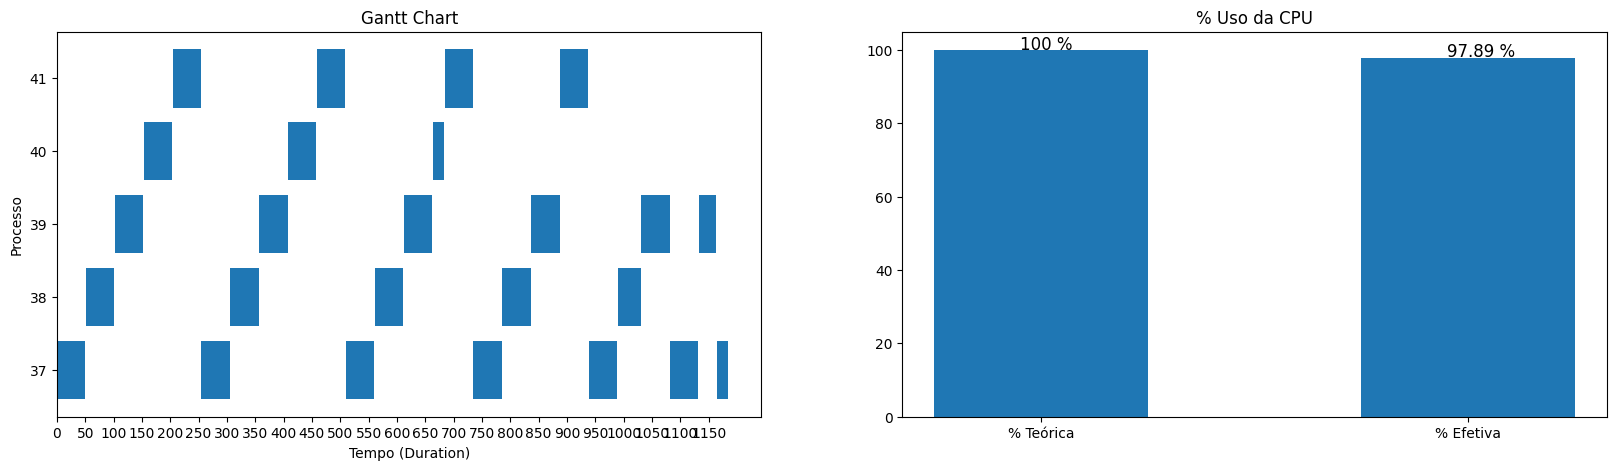

In [136]:
# Plot do Gráfico de Escalonamento em um Gantt Chart

import matplotlib.pyplot as plt

plt.style.use('fast')

# Figura 'Pai'
figure = plt.figure(figsize=(20,5))

# Figura 'Filha' 1 
figure.add_subplot(1, 2, 1)
plt.title('Gantt Chart')
plt.xlabel('Tempo (Duration)')
plt.ylabel('Processo')
plt.xticks(range(0, scheduler.clock, scheduler.quantum))

# Desenha as barras
plt.barh(y=df['Process'], left=df['Start'], width=df['Duration'])

# Figura 'Filha' 2
effective_ratio = round(cpu_utilization_ratio() * 100, 2)

figure.add_subplot(1, 2, 2)
labels = ['% Teórica', '% Efetiva']
vals = [100, effective_ratio]
plt.bar(labels, vals, width=0.5)
plt.title('% Uso da CPU')

for idx, val in enumerate(vals):
    txt = f'{val} %'
    x_coord = idx - 0.05
    y_coord = val + 0.30
    
    plt.text(x=x_coord, y=y_coord, s=txt, fontsize=12)

plt.show()

In [137]:
# Cálculo dos Tempos Médios

n = len(processes)

def avg_waiting_time():
    return_times = df.groupby('Process').last()['End']
    total_wt = 0
    for process in processes:
        return_time = df.groupby('Process').last().loc[process.pid]['End']
        total_wt += (return_time - process.burst_duration)
    return total_wt / n

def avg_return_time():
    total_rt = df.groupby('Process').last()['End'].sum()
    return total_rt / n

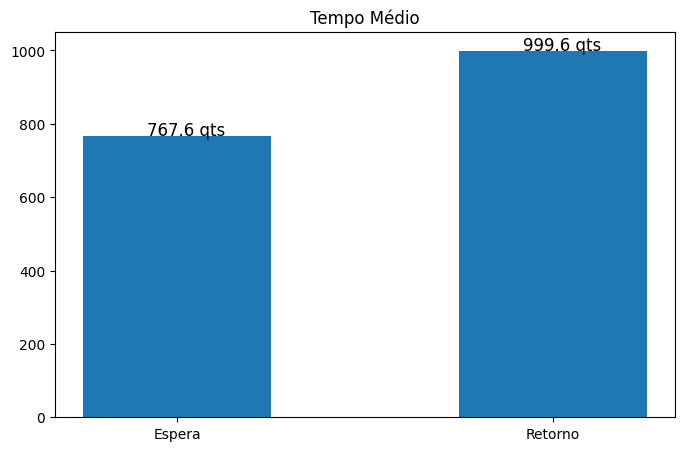

In [138]:
# Plot do Gráfico de Tempos Médios

labels = ['Espera', 'Retorno']
vals = [
    round(avg_waiting_time(), 2),
    round(avg_return_time(), 2)
]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(labels, vals, width=0.5)

ax.set_title('Tempo Médio')

for idx, val in enumerate(vals):
    txt = f'{val} qts'
    x_coord = idx - 0.08
    y_coord = val + 0.15

    ax.text(x=x_coord, y=y_coord, s=txt, fontsize=12)


In [139]:
df.groupby('Process').last()['End'].loc[p.pid]

1184.0

In [140]:
from math import ceil

def throughput():
    middle_timeline =  ceil(scheduler.clock / 2)

    end_times = df.groupby('Process').last()['End']

    first_half = []
    second_half = []

    for p in processes:
        end_time = end_times.loc[p.pid]

        if end_time <= middle_timeline:
            first_half.append(p)
        else:
            second_half.append(p)

    return [first_half, second_half]

Text(0.5, 1.0, 'Vazão ao longo do tempo')

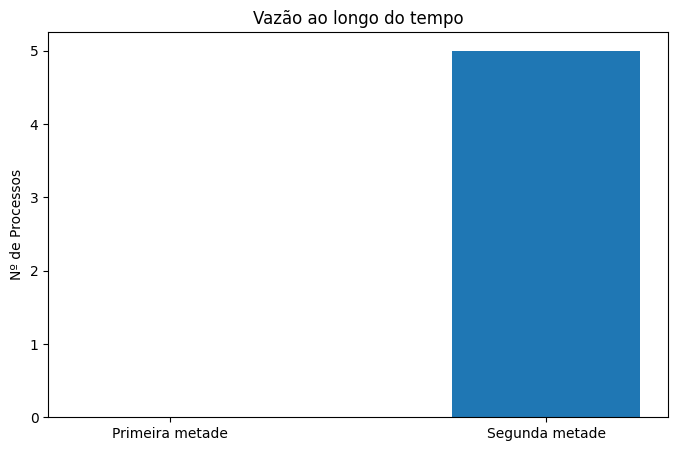

In [141]:
# Plot do Gráfico da Vazão

labels = ['Primeira metade', 'Segunda metade']
vals = [
    len(throughput()[0]),
    len(throughput()[1])
]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(labels, vals, width=0.5)
ax.set_ylabel('Nº de Processos')

ax.set_title('Vazão ao longo do tempo')